<a href="https://colab.research.google.com/github/adityaprasad2005/Hybrid_Chemfoam_solver/blob/main/Hybrid_chemfoam_MLP_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**We train a Residual connection MLP model on combusition chemistry dataset**

**Import Libraries**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import MinMaxScaler # used for normalisation
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

**MLP model Definitions**

In [2]:

# Model Definitions

class ResidualBlock(nn.Module):
    def __init__(self, input_dim=11):
        super(ResidualBlock, self).__init__()

        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, input_dim)

        self.activation = nn.LeakyReLU(negative_slope=0.15)
        self._init_weights()

    def _init_weights(self):

        for layer in [self.fc1, self.fc2, self.fc3]:
            nn.init.kaiming_normal_(layer.weight, a=0.15, nonlinearity='leaky_relu')
            # nn.init.kaiming_normal_: This is the function from PyTorch's nn.init module that performs Kaiming He initialization with a normal distribution. It's a technique designed to help with training deep neural networks by setting the initial weights appropriately.
            # initializes the weights of a neural network layer using Kaiming He initialization (also known as He initialization) with a specific configuration for LeakyReLU activation.
            # nonlinearity='leaky_relu': This specifies that the initialization should be tailored for a LeakyReLU activation function. The initialization method takes into account the properties of the activation function to ensure better convergence during training.
            # He initialisation of weights: Designed for ReLU-type activations, which zero out negative inputs and also can counter the probkem of vanishing gradients. It also Keeps variance consistent after ReLU.

            nn.init.constant_(layer.bias, 0)
            # nn.init.constant_: This is a function from PyTorch's nn.init module that initializes a tensor with a constant value.

    def forward(self, x):
        residual = x
        out = self.activation(self.fc1(x))
        out = self.activation(self.fc2(out))
        out = self.activation(self.fc3(out))

        return out + residual

class ResidualMLP(nn.Module):
    def __init__(self, input_dim=11, num_blocks=4):
        super(ResidualMLP, self).__init__()

        self.blocks = nn.ModuleList([ResidualBlock(input_dim) for _ in range(num_blocks)])
        # nn.ModuleList: This is a container from PyTorch that holds a list of modules (in this case, ResidualBlock instances). Using nn.ModuleList is important because
        # it registers the modules as submodules of the ResidualMLP, making them accessible for operations like parameter updates and saving/loading the model.
        # This line creates a sequence of ResidualBlock units, effectively building the layers of your Residual MLP. num_blocks determines how many of these blocks
        #  are stacked together. The nn.ModuleList makes sure these blocks are properly managed within the overall model structure.

    def forward(self, x):
        residual = x
        for block in self.blocks:
            x = block(x)
        return x + residual

# The vanishing gradient problem is a fundamental issue in training deep neural networks, where gradients (used to update weights) become extremely small as they are propagated backward through the layers. When this happens, earlier layers learn very slowly or stop learning entirely.
# in deep networks, the gradient is a chain of derivatives through all the layers, If each derivative is < 1, then the product shrinks exponentially with the number of layers. So for early layers (closer to the input), the gradient is nearly zero.
# SOlutions to the problem of vanishing gradients:
# 1. ReLU / LeakyReLU activations	Derivatives are 1 or close to 1, so gradients don’t vanish
# 2. Batch Normalization	Keeps activations and gradients in a healthy range
# 3. Residual Connections	Add identity paths for direct gradient flow
# 4. Good weight initialization	E.g., He or Xavier initialization keeps signal stable across layers



**Training and Evaluation functions**

In [3]:
# Training Utilities
def train_model(model, dataloader, optimizer, criterion, device='cuda'):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
    return running_loss / len(dataloader.dataset)



def evaluate_model(model, dataloader, criterion, device='cuda'):
    model.eval()  # In PyTorch, model.eval() is used to set your model to evaluation mode. When in evaluation mode, certain layers like dropout and batch normalization behave differently compared to training mode. For instance, dropout is deactivated (neurons are not randomly dropped out), and batch normalization uses running statistics instead of calculating them on the current batch.
    running_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            running_loss += loss.item() * X_batch.size(0)

    return running_loss / len(dataloader.dataset)

**Training Script**

**Use of __name__ = __main__**
In Python, every module (a .py file) has a built-in attribute called __name__.
When a module is run directly (as the main program), its __name__ is set to "__main__".
When a module is imported into another module, its __name__ is set to the module's filename (without the .py extension).
This conditional block is used to ensure that certain code is executed only when the script is run directly, not when it's imported as a module.
This is crucial for 1.Organizing Code 2. Avoiding Unintended Execution

In [4]:
# Mount the Google drive
from google.colab import drive
drive.mount('/content/drive')

# When you mount Google Drive in Colab, you're basically connecting your Google Drive storage to the Colab virtual machine.

Mounted at /content/drive


In [7]:
file_path = r"/content/drive/MyDrive/H2_Combustion_Dataset/T1000_P202650.out"

data = pd.read_csv(file_path, sep='\t', skiprows=1)

data.head()

,t,T,Qdot,P,H2,H,O2,O,OH,HO2,H2O2,H2O,AR,N2
0,0.00001,1000.0,441.079,202650,0.004231,1.889290e-11,0.004231,3.978610e-12,1.331490e-12,5.475540e-11,2.775040e-14,3.444760e-11,0,0.01591
1,0.00002,1000.0,3948.270,202650,0.004231,4.878770e-11,0.004231,1.082500e-11,3.555020e-12,1.979020e-10,1.785350e-13,1.711680e-10,0,0.01591
2,0.00003,1000.0,9642.360,202650,0.004231,9.739990e-11,0.004231,2.195680e-11,7.171030e-12,4.843580e-10,5.988890e-13,4.742660e-10,0,0.01591
3,0.00004,1000.0,18899.100,202650,0.004231,1.764950e-10,0.004231,4.006770e-11,1.305630e-11,1.003600e-09,1.528800e-12,1.047850e-09,0,0.01591
4,0.00005,1000.0,33974.800,202650,0.004231,3.052980e-10,0.004231,6.955890e-11,2.264570e-11,1.901510e-09,3.366060e-12,2.061980e-09,0,0.01591


In [9]:
print(len(data))

1000000


**Initialise the model**

In [10]:
# Hyperparameters
input_dim = 11       # T, Qdot, species_conc.- Ar i.e we have 9 species and T and Qdot
num_blocks = 9
batch_size = 5000
epochs = 50
lr = 1e-3
weight_decay = 1e-5


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Yes, you will lose the saved model weights file when your Colab session expires. This is because the /content directory is ephemeral and is reset every time you start a new Colab session.
# To avoid losing your model weights, you need to save them to a persistent storage location like Google Drive.
model_save_path = "/content/drive/MyDrive/H2_Combustion_Dataset/best_model_weights_v2"

# Model, Optimizer, Loss
model = ResidualMLP(input_dim=input_dim, num_blocks=num_blocks).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # weight_decay refers to L2 regularization. It's a technique used to prevent overfitting by adding a penalty term to the loss function. This penalty term is proportional to the square of the model's weights.Regularization: L2 regularization encourages the model to have smaller weights, making it less sensitive to individual data points and thus less prone to overfitting.
criterion = nn.MSELoss()

# This line creates a learning rate scheduler called StepLR. A learning rate scheduler is a tool that adjusts the learning rate
# step_size=10: The learning rate will be reduced every 10 epochs.
# gamma=0.5: The learning rate will be multiplied by 0.5 (halved) at each step.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


Using device: cuda


**If model is previously trained, load the best weights**

In [ ]:
model.load_state_dict(torch.load(model_save_path, map_location=device))

# While it might seem counterintuitive to set the model to evaluation mode (model.eval()) when you intend to further train it.When loading a pre-trained model, certain layers like dropout and batch normalization might behave differently during training and evaluation.
# By calling model.eval() immediately after loading the weights, you ensure that these layers are in the correct state for inference, which is important for evaluating the model's initial performance on the new dataset before further training.
# However, before you start the further training loop, you need to switch the model back to training mode using model.train(). This ensures that dropout and batch normalization behave as expected during training.
model.eval()

ResidualMLP(
  (blocks): ModuleList(
    (0-3): 4 x ResidualBlock(
      (fc1): Linear(in_features=11, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=128, bias=True)
      (fc3): Linear(in_features=128, out_features=11, bias=True)
      (activation): LeakyReLU(negative_slope=0.15)
    )
  )
)

**Convert the dataset**

In [11]:
# Load Dataset
file_path = file_path

data = pd.read_csv(file_path, sep='\t', skiprows=1)

# Preprocessing
data = data.drop(['t', 'AR', 'P'], axis=1)  # Drop columns 't' and 'AR' and 'P'
data = data.dropna().reset_index(drop=True)  # remove missing data

####
# In the best_model_weights_v2 file we save the model weights which is trained in the following
# We train our model on the file T1000_P202650
# We train on 11 variables that include T, QDot, species-Ar
# We predict on the next state(i.e 11vars) which is 1e-5 time step ahead in time

# We are now following this minimal approach, bcz earlier when we were using 12 vars (included P as well)
# We could'nt bring val_error down. This is due to unavailability of a common normalisation scheme
####

# Normalise the dataset
# Create a MinMaxScaler object for each column
scaler_T = MinMaxScaler()
scaler_Qdot = MinMaxScaler()

# Fit the scalers to the respective columns and transform the data
data['T'] = scaler_T.fit_transform(data[['T']])
data['Qdot'] = scaler_Qdot.fit_transform(data[['Qdot']])

eps = 1e-10
scaler_obj_dict = {}
for i in data.columns:
    if i not in ['T', 'Qdot']:
      data[i] = np.log(1+ data[i]/eps)
      scaler_obj_dict[i] = MinMaxScaler()
      data[i] = scaler_obj_dict[i].fit_transform(data[[i]])


# Conversion pd.Dataframe to np.array
X = data.values.astype(np.float32)  # data.values extracts the underlying np array from the pd dataframe
y = np.roll(X, -1, axis=0)[:-1]  # Shift data by one row to create targets, remove last row
X = X[:-1]  # Remove last row from input as it has no target

# Dataset conversion to tensors
tensor_X = torch.tensor(X) # convert np array to torch 2D tensor
tensor_y = torch.tensor(y)
dataset = TensorDataset(tensor_X, tensor_y)
# If you access dataset[0], it will return a tuple like (tensor_X[0], tensor_y[0]), where tensor_X[0] represents the input features for the first data point and tensor_y[0] represents the corresponding target value.

# Train Test Validation sizes
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

**Train the model on above converted dataset**

In [12]:
# Main Training Script
if __name__ == "__main__":

    # Dataloading
    # DataLoader is a powerful utility in PyTorch that helps you efficiently iterate through your dataset during training. It handles tasks like batching, shuffling, and loading data in parallel.
    # shuffle=True: This indicates whether to shuffle the dataset before each epoch (a full pass through the data). Shuffling helps prevent the model from learning patterns specific to the order of data and generally improves training performance.
    # num_workers=4: This sets the number of worker processes to use for data loading. Using multiple workers can significantly speed up data loading, especially for large datasets.
    # pin_memory=True: This enables memory pinning, which can further accelerate data transfer to the GPU (if you're using one).
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    # Training Loop
    best_val_loss = float("inf") # assign it inf value
    for epoch in range(epochs):
        train_loss = train_model(model, train_loader, optimizer, criterion, device)
        val_loss = evaluate_model(model, val_loader, criterion, device)
        scheduler.step() # Just to set the optimum learning rate

        print(f"Epoch {epoch+1:02d}: Train Loss = {train_loss:.6f} | Val Loss = {val_loss:.6f}")

        # Save best model weights
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_save_path)
            print(f"✔️  Best model saved at epoch {epoch+1} with val loss {val_loss:.6f}")

    print(f"\nTraining complete on data file: {file_path}. \nBest model saved as '{model_save_path}'")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 01: Train Loss = 31.393800 | Val Loss = 0.014177
✔️  Best model saved at epoch 1 with val loss 0.014177
Epoch 02: Train Loss = 0.009161 | Val Loss = 0.006262
✔️  Best model saved at epoch 2 with val loss 0.006262
Epoch 03: Train Loss = 0.004709 | Val Loss = 0.003371
✔️  Best model saved at epoch 3 with val loss 0.003371
Epoch 04: Train Loss = 0.002518 | Val Loss = 0.001812
✔️  Best model saved at epoch 4 with val loss 0.001812
Epoch 05: Train Loss = 0.001385 | Val Loss = 0.001047
✔️  Best model saved at epoch 5 with val loss 0.001047
Epoch 06: Train Loss = 0.000821 | Val Loss = 0.000629
✔️  Best model saved at epoch 6 with val loss 0.000629
Epoch 07: Train Loss = 0.000490 | Val Loss = 0.000371
✔️  Best model saved at epoch 7 with val loss 0.000371
Epoch 08: Train Loss = 0.000286 | Val Loss = 0.000216
✔️  Best model saved at epoch 8 with val loss 0.000216
Epoch 09: Train Loss = 0.000167 | Val Loss = 0.000128
✔️  Best model saved at epoch 9 with val loss 0.000128
Epoch 10: Train Lo

**Making Predictions on the Trained Model**

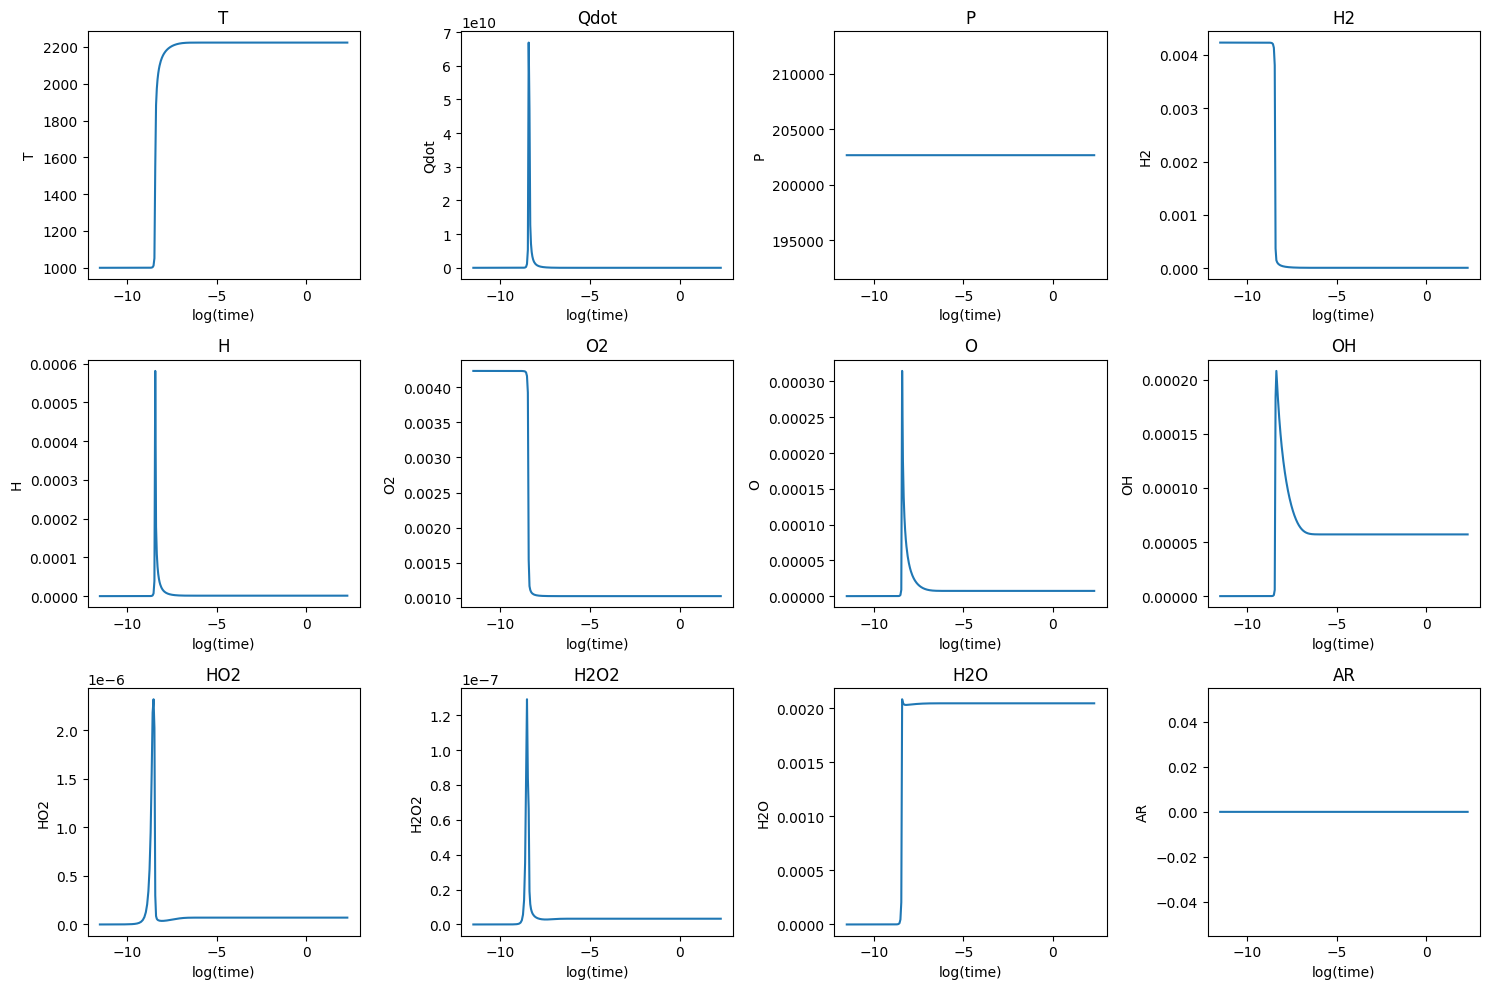

In [13]:
# Plotting the original data
orig_data = pd.read_csv(file_path, sep='\t', skiprows=1)

orig_data.head()
fig, axs = plt.subplots(3, 4, figsize=(15, 10))  # Use fig, axs for clarity

for i in range(3):
    for j in range(4):
        column_name = orig_data.columns[i * 4 + j + 1]
        axs[i, j].plot(np.log(orig_data['t']), orig_data[column_name])
        axs[i, j].set_title(column_name)  # Set title for each subplot
        axs[i, j].set_xlabel('log(time)')
        axs[i, j].set_ylabel(column_name)

plt.tight_layout()
plt.show()




<ipython-input-17-29ece89d8e27>:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pred_data.fillna(np.nan, inplace=True)  # Fill with NaN values
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(u

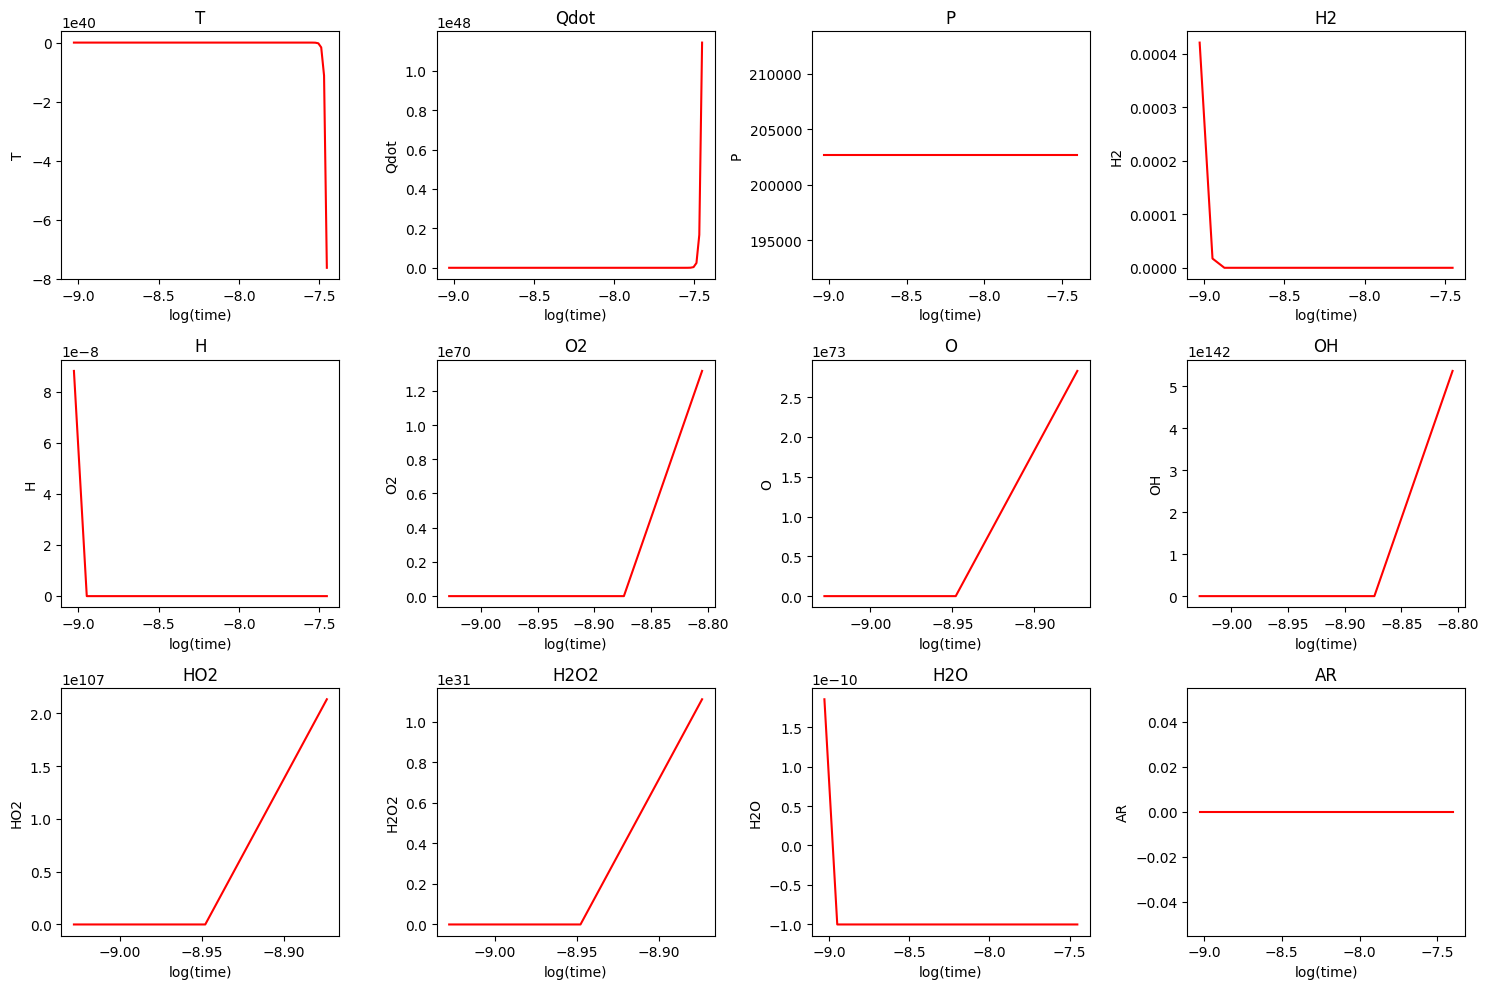

In [17]:
# Plotting the predicted dataset

# We recursively predict from t= 0.1 s
start_time = 0.0001
row_num = int(start_time/1e-5)    # time/time_step_size
input_row = orig_data.iloc[row_num]
input_data = input_row.drop(['t', 'AR', 'P']).to_frame().T  # Convert to DataFrame

# Apply normalization using stored scalers
input_data['T'] = scaler_T.transform(input_data[['T']])
input_data['Qdot'] = scaler_Qdot.transform(input_data[['Qdot']])
for i in input_data.columns:
    if i not in ['T', 'Qdot']:
        input_data[i] = np.log(1 + input_data[i] / eps)
        input_data[i] = scaler_obj_dict[i].transform(input_data[[i]])

input_tensor = torch.tensor(input_data.values.astype(np.float32)).unsqueeze(0).to(device)  #Purpose of unsqueeze(0):Adding a Batch Dimension: In PyTorch, neural networks often expect input data in batches. Even if you're providing a single input sample, it needs to be represented as a batch of size 1. unsqueeze(0) adds a new dimension of size 1 at the 0th position (the outermost dimension) of the tensor. This effectively creates a batch dimension, transforming your input from a 1D tensor (representing a single data point) into a 2D tensor (representing a batch of 1 data point).

time_steps_ahead = 50
pred_data = pd.DataFrame(index=range(time_steps_ahead), columns=orig_data.columns)  # Create 1000 rows
pred_data.fillna(np.nan, inplace=True)  # Fill with NaN values

# generating predictions for the next 1000 steps ahead
for i in range(time_steps_ahead):
  with torch.no_grad():
      output_tensor = model(input_tensor)

      j = 0
      for col in orig_data.columns:
        if col not in ['t', 'P', 'AR']:
          pred_data.loc[i, col] = output_tensor.cpu().squeeze().numpy()[j]
          j += 1

      pred_data.loc[i, 't'] = input_row['t'] + (i+1)*1e-5
      pred_data.loc[i, 'AR'] = input_row['AR']
      pred_data.loc[i, 'P'] = input_row['P']

      input_tensor = output_tensor.unsqueeze(0).to(device)

# Apply inverse transformation using stored scalers
pred_data['T'] = scaler_T.inverse_transform(pred_data[['T']])
pred_data['Qdot'] = scaler_Qdot.inverse_transform(pred_data[['Qdot']])
for i in pred_data.columns:
  if i not in ['T', 'Qdot', 't', 'AR', 'P']:
    pred_data[i] = scaler_obj_dict[i].inverse_transform(pred_data[[i]])
    pred_data[i] = eps*(np.exp(pred_data[i])-1)


# Plotting the predicted data

fig, axs = plt.subplots(3, 4, figsize=(15, 10))  # Use fig, axs for clarity

for i in range(3):
    for j in range(4):
        column_name = pred_data.columns[i * 4 + j + 1]
        axs[i, j].plot(np.log(pred_data['t']), pred_data[column_name], color= 'red')
        axs[i, j].set_title(column_name)  # Set title for each subplot
        axs[i, j].set_xlabel('log(time)')
        axs[i, j].set_ylabel(column_name)

plt.tight_layout()
plt.show()



In [18]:
pred_data

,t,T,Qdot,P,H2,H,O2,O,OH,HO2,H2O2,H2O,AR,N2
0,0.00012,1.447189e+03,6.164091e+10,202650.0,4.212274e-04,8.809700e-08,3.043763e-02,1.988568e-09,5.694552e-09,9.083749e-08,-9.532851e-11,1.851913e-10,0.0,3.013053e-02
1,0.00013,3.248963e+03,2.355765e+11,202650.0,1.730049e-05,-1.000000e-10,7.705658e+02,1.983922e+16,-1.000000e-10,4.181144e+08,-9.998517e-11,-9.999976e-11,0.0,9.895077e-02
2,0.00014,-5.668926e+03,6.777168e+11,202650.0,-1.000000e-10,-1.000000e-10,2.098687e+15,2.829142e+73,-1.000000e-10,2.133762e+107,1.111395e+31,-1.000000e-10,0.0,1.295937e+01
3,0.00015,-1.020144e+05,6.084770e+12,202650.0,-1.000000e-10,-1.000000e-10,1.316229e+70,inf,5.370954e+142,inf,inf,-1.000000e-10,0.0,1.237351e+12
4,0.00016,-6.985573e+05,1.704162e+13,202650.0,-1.000000e-10,-1.000000e-10,inf,inf,inf,inf,inf,-1.000000e-10,0.0,3.140076e+88
5,0.00017,-4.192761e+06,4.434467e+13,202650.0,-1.000000e-10,-1.000000e-10,inf,inf,inf,inf,inf,-1.000000e-10,0.0,inf
6,0.00018,-2.961204e+07,3.431632e+14,202650.0,-1.000000e-10,-1.000000e-10,inf,inf,inf,inf,inf,-1.000000e-10,0.0,inf
7,0.00019,-2.079423e+08,3.103695e+15,202650.0,-1.000000e-10,-1.000000e-10,inf,inf,inf,inf,inf,-1.000000e-10,0.0,inf
8,0.00020,-1.455211e+09,2.391397e+16,202650.0,-1.000000e-10,-1.000000e-10,inf,inf,inf,inf,inf,-1.000000e-10,0.0,inf
9,0.00021,-9.965974e+09,1.581240e+17,202650.0,-1.000000e-10,-1.000000e-10,inf,inf,inf,inf,inf,-1.000000e-10,0.0,inf


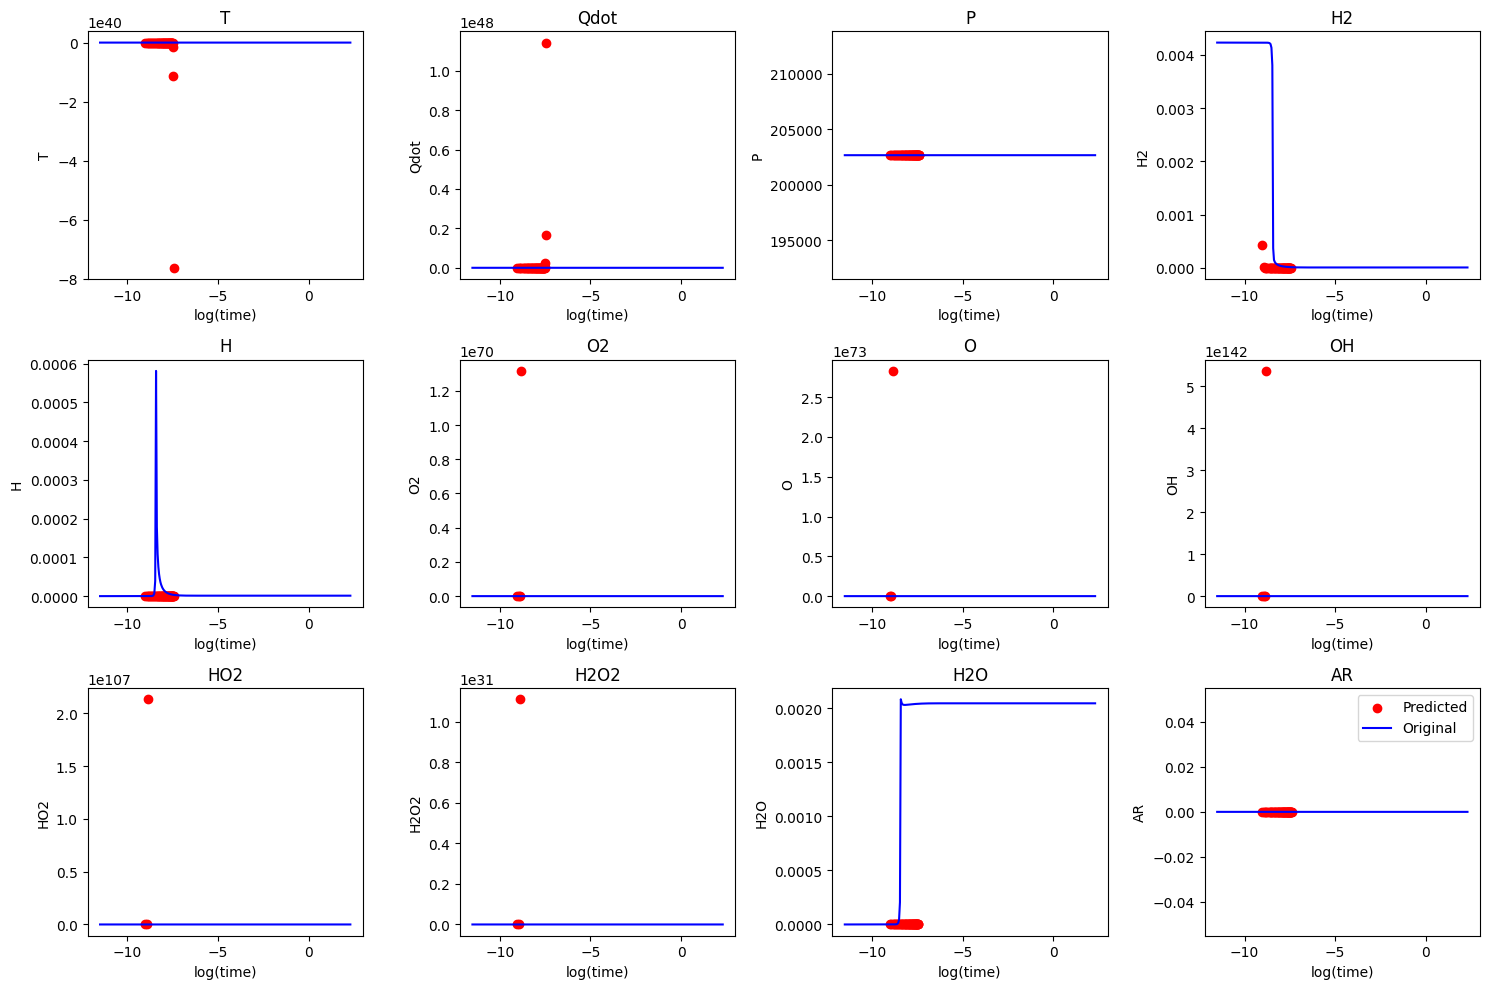

In [19]:
# plotting the original and predicted data

fig, axs = plt.subplots(3, 4, figsize=(15, 10))  # Use fig, axs for clarity

for i in range(3):
    for j in range(4):
        column_name = pred_data.columns[i * 4 + j + 1]
        axs[i, j].scatter(np.log(pred_data['t']), pred_data[column_name], label= 'Predicted', color= 'red')
        axs[i, j].plot(np.log(orig_data['t']), orig_data[column_name], label= 'Original', color = 'blue')
        axs[i, j].set_title(column_name)  # Set title for each subplot
        axs[i, j].set_xlabel('log(time)')
        axs[i, j].set_ylabel(column_name)

plt.tight_layout()
plt.legend()
plt.show()